# Introduction

The current outbreak of the novel coronavirus SARS-CoV-2, which started 
in Wuhan, Hubei Province, China, in early December 2019, has spread to many other 
countries. On January 30, 2020, the WHO Emergency Committee declared a global health 
emergency based on growing case notification rates at Chinese and international locations.

COVID-19 cases started to appear in Indonesia on March 2, 2020. Other countries 
worldwide introduced lockdown measures during this time, but Indonesia offered incentives 
to promote tourism instead. This late response from the government has made Indonesian
vulnerable to the pandemic. On March 13, 2020, the government set up a Task Force for 
Rapid Response to COVID-19, two days after the first confirmed death.

Having a machine learning model to predict future covid-19 cases in Indonesia would help the government in preparing for prevention of the pandemic, which can reduce the amount of expenses for the countermeasures indirectly.



In [ ]:
import numpy as np
import pandas as pd

# Visualization
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore Warnings on Prophet
import warnings  
warnings.filterwarnings('ignore')

# Data Gathering

The data used for this modelling is obtained from CSSEGISandData, a repository which provides the covid-19 cases data from all around the world, [you can see the data here](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv). We sliced the data only for cases in Indonesia.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df[df['Country/Region'] == 'Indonesia']
df = df.iloc[:, 4:]
df = df.T.reset_index()
df = df.rename(columns={'index': 'ds', 148: 'y'})
df = df[df['y'] > 0]
df['ds'] = pd.to_datetime(df['ds'], format = '%m/%d/%y')
df

,ds,y
40,2020-03-02,2
41,2020-03-03,2
42,2020-03-04,2
43,2020-03-05,2
44,2020-03-06,4
...,...,...
622,2021-10-05,4221610
623,2021-10-06,4223094
624,2021-10-07,4224487
625,2021-10-08,4225871


# Exploratory Data Analysis

Since 2nd March 2020, Indonesia has accumulated a total of 4227038 covid-19 cases varying fom many range of ages.

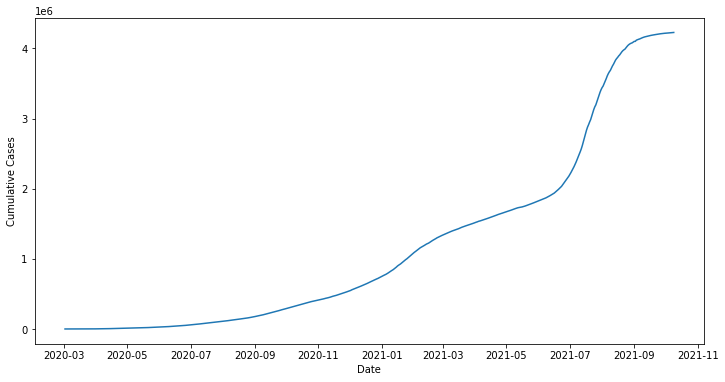

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="ds", y="y")
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.show()

# Data Preparation

For the data, we tried to split the data into 95% training and 5% testing data. This is needed in order to get an estimation on how good is our model when it is fit against our data.

In [ ]:
from sklearn.model_selection import train_test_split

X = df["ds"]
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42,shuffle=False)

train_data = {'ds': X_train, 'y': y_train}
train_data = pd.DataFrame(train_data)
train_data['ds'] = pd.to_datetime(train_data['ds'])
train_data['cap'] = 4500000
print(train_data.shape)

test_data = {'ds': X_test, 'y': y_test}
test_data = pd.DataFrame(test_data)
test_data['ds'] = pd.to_datetime(test_data['ds'])
test_data['cap'] = 4500000
print(test_data.shape)

(557, 3)
(30, 3)


In [ ]:
train_data.tail()

,ds,y,cap
592,2021-09-05,4129020,4500000
593,2021-09-06,4133433,4500000
594,2021-09-07,4140634,4500000
595,2021-09-08,4147365,4500000
596,2021-09-09,4153355,4500000


In [ ]:
test_data.tail()

,ds,y,cap
622,2021-10-05,4221610,4500000
623,2021-10-06,4223094,4500000
624,2021-10-07,4224487,4500000
625,2021-10-08,4225871,4500000
626,2021-10-09,4227038,4500000


# Prophet

Prophet is a forecasting library developed by Facebook and is
implemented in R and Python. Prophet forecast time series data based on simple linear 
equations, which fit the non-linear trends by adding the daily, weekly, and yearly seasonality 
by considering holiday effects. It is usually used for uncertain options, trend options, 
holiday options, seasonal options, and added regression/model diagnostics. Prophet's 
limitation is that Prophet does not allow non-Gaussian noise distribution (currently). Prophet 
did not take into account the autocorrelation of the residuals, and it did not consider 
stochastic trends.

![Prophet](https://miro.medium.com/max/875/1*NG9XQ0CCpd6cAUI3DoRG0g.png)

This Prophet model also uses the api provided from SKLearn, which makes it really easy for sklearn users to build a model using the .fit() and .predict() functions

In [ ]:
from fbprophet import Prophet

m = Prophet(growth='logistic',interval_width=0.95, 
            changepoint_prior_scale=0.5,
            seasonality_prior_scale = 20,
             holidays_prior_scale = 25,
            seasonality_mode = 'additive',
            changepoint_range=0.95, daily_seasonality=True,
            weekly_seasonality=False)
m.add_country_holidays(country_name='ID')
m.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=30)
future['cap'] = 4500000

Prophet has two columns: "ds" and "y," to store data time 
series and corresponding values of the time series. Prophet uses a decomposable time series 
model with three main components: trend, seasonality, and holidays.

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
582,2021-10-05,4.352065e+06,4.328176e+06,4.374790e+06
583,2021-10-06,4.356138e+06,4.331754e+06,4.378556e+06
584,2021-10-07,4.360080e+06,4.336326e+06,4.382485e+06
585,2021-10-08,4.363897e+06,4.336207e+06,4.386755e+06
586,2021-10-09,4.367592e+06,4.343642e+06,4.388392e+06


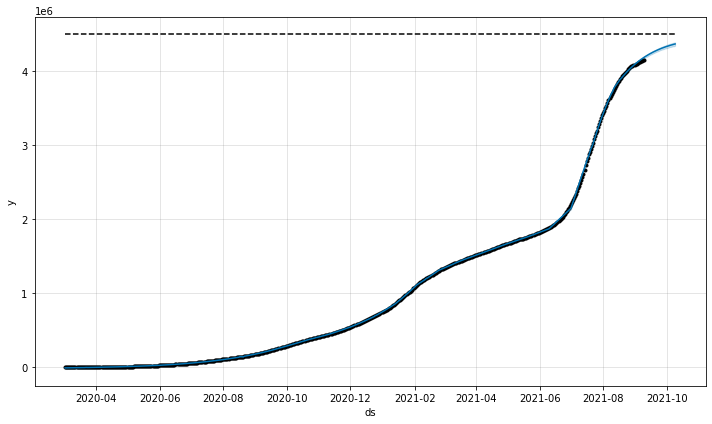

In [ ]:
confirmed_forecast_plot = m.plot(forecast)

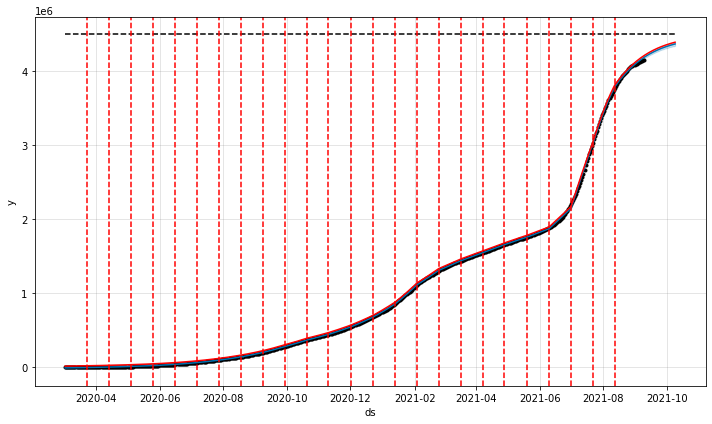

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
forecast_after = forecast[forecast["ds"] > "2021-09-09"] 

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Total Cases', x=train_data['ds'], y=train_data['y']),
    go.Bar(name='Total Cases Forecasted', x=forecast_after['ds'], y=forecast_after['yhat'])
])

fig.update_layout(barmode='group', title='Indonesian Cases + Forecasted Cases')
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Total Cases', x=train_data['ds'], y=train_data['y']),
    go.Bar(name='Future Cases', x=test_data['ds'], y=test_data['y'])
])

fig.update_layout(barmode='group', title='Indonesian Cases + Future Cases')
fig.show()

To see how accurate the model is, we do some calculations with several functions
that are available in Scikit-learn library. Following are the metrics and results of the 
calculations used: 

• Max Error
Max Error is a metric that captures the worst-case error between the predicted value 
and the actual value.

• Mean Absolute Error
Mean Absolute Error (MAE) is a risk metric corresponding to the expected value of 
the absolute error loss or l1-norm loss.
 
• Root Mean Squared Error
Root Mean Squared Error (RMSE) is a risk metric corresponding to the expected 
value of the squared (quadratic) error or loss

• R2 Score
R
2
is a representation of the proportion of variance (of y) that has been explained by 
the independent variables in the model. It indicates goodness of fit and, therefore, a 
measure of how well-unseen samples are likely to be predicted by the model, though 
the proportion of explained variance.
 

In [ ]:
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Max Error: " + str(max_error(test_data["y"], forecast_after["yhat"])))
print("Mean Absolute Error: " + str(mean_absolute_error(test_data["y"], forecast_after["yhat"])))
print("R2 Score: " + str(r2_score(test_data["y"], forecast_after["yhat"])))
print("Root Mean Square Error: " + str(mean_squared_error(test_data["y"], forecast_after["yhat"], squared=False)))

Max Error: 140553.69158377033
Mean Absolute Error: 93101.01537067961
R2 Score: -22.945944651043746
Root Mean Square Error: 98294.18625395828


# Final Prediction

For the final prediction, we decided to use the data only from 8th August to 09th October. This is done to prevent any bias caused from the previous covid-19 outbreak by Delta version.

In [ ]:
df2 = df[(df['ds'] >= '2021-08-24') & (df['ds'] <= '2021-10-09')]
df2

,ds,y,label
580,2021-08-24,4008166,now
581,2021-08-25,4026837,now
582,2021-08-26,4043736,now
583,2021-08-27,4056354,now
584,2021-08-28,4066404,now
585,2021-08-29,4073831,now
586,2021-08-30,4079267,now
587,2021-08-31,4089801,now
588,2021-09-01,4100138,now
589,2021-09-02,4100138,now


In [ ]:
from fbprophet import Prophet
m2 = Prophet(growth='linear',interval_width=0.95, 
            changepoint_prior_scale=0.5,
            seasonality_prior_scale = 20,
             holidays_prior_scale = 25,
            seasonality_mode = 'additive',
            changepoint_range=0.95, daily_seasonality=True,
            weekly_seasonality=False)
m2.add_country_holidays(country_name='ID')
m2.fit(df2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future2 = m2.make_future_dataframe(periods=100)

In [ ]:
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100)

,ds,yhat,yhat_lower,yhat_upper
47,2021-10-10,4.228455e+06,4.225814e+06,4.231022e+06
48,2021-10-11,4.229792e+06,4.223844e+06,4.236386e+06
49,2021-10-12,4.231130e+06,4.219833e+06,4.242596e+06
50,2021-10-13,4.232467e+06,4.215115e+06,4.250822e+06
51,2021-10-14,4.233804e+06,4.209119e+06,4.258547e+06
...,...,...,...,...
142,2022-01-13,4.355497e+06,2.457060e+06,6.400875e+06
143,2022-01-14,4.356835e+06,2.418180e+06,6.432199e+06
144,2022-01-15,4.358172e+06,2.379961e+06,6.461466e+06
145,2022-01-16,4.359509e+06,2.347582e+06,6.492360e+06


In [ ]:
final_forecast = forecast2[forecast2["ds"] > "2021-10-09"] 

In [ ]:
final_forecast.shape
# df.shape

(100, 58)

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Total Cases', x=df['ds'], y=df['y']),
    go.Bar(name='Future Cases', x=final_forecast['ds'], y=final_forecast['yhat'])
])

fig.update_layout(barmode='group', title='Indonesian Cases + Future Cases')
fig.show()

After using the data, we quite get a good prediction for the next 100 days to 17th January 2022

In [ ]:
df['label'] = 'now'

In [ ]:
final_forecast2 = final_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
print(final_forecast2.shape)
final_forecast2.rename({'yhat' : 'y'}, axis = 1, inplace = True)
print(final_forecast2.shape)
final_forecast2['label'] = 'future'
print(final_forecast2.shape)

(100, 4)
(100, 4)
(100, 5)


In [ ]:
final_forecast2.shape

(100, 5)

In [ ]:
final_df = pd.concat([df, final_forecast2])

In [ ]:
final_df

,ds,y,label,yhat_upper,yhat_lower
40,2020-03-02,2.000000e+00,now,NaN,NaN
41,2020-03-03,2.000000e+00,now,NaN,NaN
42,2020-03-04,2.000000e+00,now,NaN,NaN
43,2020-03-05,2.000000e+00,now,NaN,NaN
44,2020-03-06,4.000000e+00,now,NaN,NaN
...,...,...,...,...,...
142,2022-01-13,4.355497e+06,future,6.366532e+06,2.465245e+06
143,2022-01-14,4.356835e+06,future,6.404645e+06,2.435182e+06
144,2022-01-15,4.358172e+06,future,6.430966e+06,2.404755e+06
145,2022-01-16,4.359509e+06,future,6.453955e+06,2.373067e+06


In [ ]:
final_df.to_csv('df-gabungan-covid-prediksi.csv', index = False)

In [ ]:
from google import colab
from google.colab import files

files.download('df-gabungan-covid-prediksi.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>